# Health risks and life expectancy

Imports and set magics:

In [1]:
# run installations
!pip install geopandas
!pip install linearmodels

In [2]:
# packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import plotly.graph_objects as go
import ipywidgets as widgets
from linearmodels.panel import PanelOLS

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
from dataproject import *

# Our data 

In this data project we will investigate how daily smoking, social support and alcohol consumption affects life expectancy at age 65 years old. The explanatory variabels are chosen based on an expected effect. All data are taken from the OECD database (https://data.oecd.org) and are imported as csv-files. All datasets contain observations in the interval from 1960 to 2021. We import at the following datasets:

-  **lifeexp65.csv:** Life expectancy at 65 is measured as the average number of years that a person at 65 years can be expected to live assuming that age-specifikc mortality levels remain constant. The dataset contains observations for men and women individually. We also import the two datasets *men_lifeexp65.csv* and *women_lifeexp65.csv* which contain *lifeexp65* data for men and women respectively in 2020. 

-  **alcohol.csv:** Alchol consumption is defined as annual sales of pure alcohol in litres per person aged 15 years and older. The dataset contains obervations for the entire population.

-  **smokers.csv:** Daily smokers are defined as the population aged 15 years and older who are reporting to smoke every day. The indicator is measured as a percentage of the population aged 15 years and older and is stated for men, women and the total population.

-  **socsupport.csv:** Social support indicates the share of people who report having friends or relatives whom they can count on in times of trouble. The indicator is measures as a percentage of survey respondent. Due to small sample sizes, country averages are pooled between 2010 and 2020. The survey sample is designed to be nationally representative of the population ages 15 years and older. 

To give an overview of the current lifeexpectancy on a global plan we present *lifeexp65* in two maps showing life expectancy at 65 for men and women respectively, in 2020 for data in our dataset. 

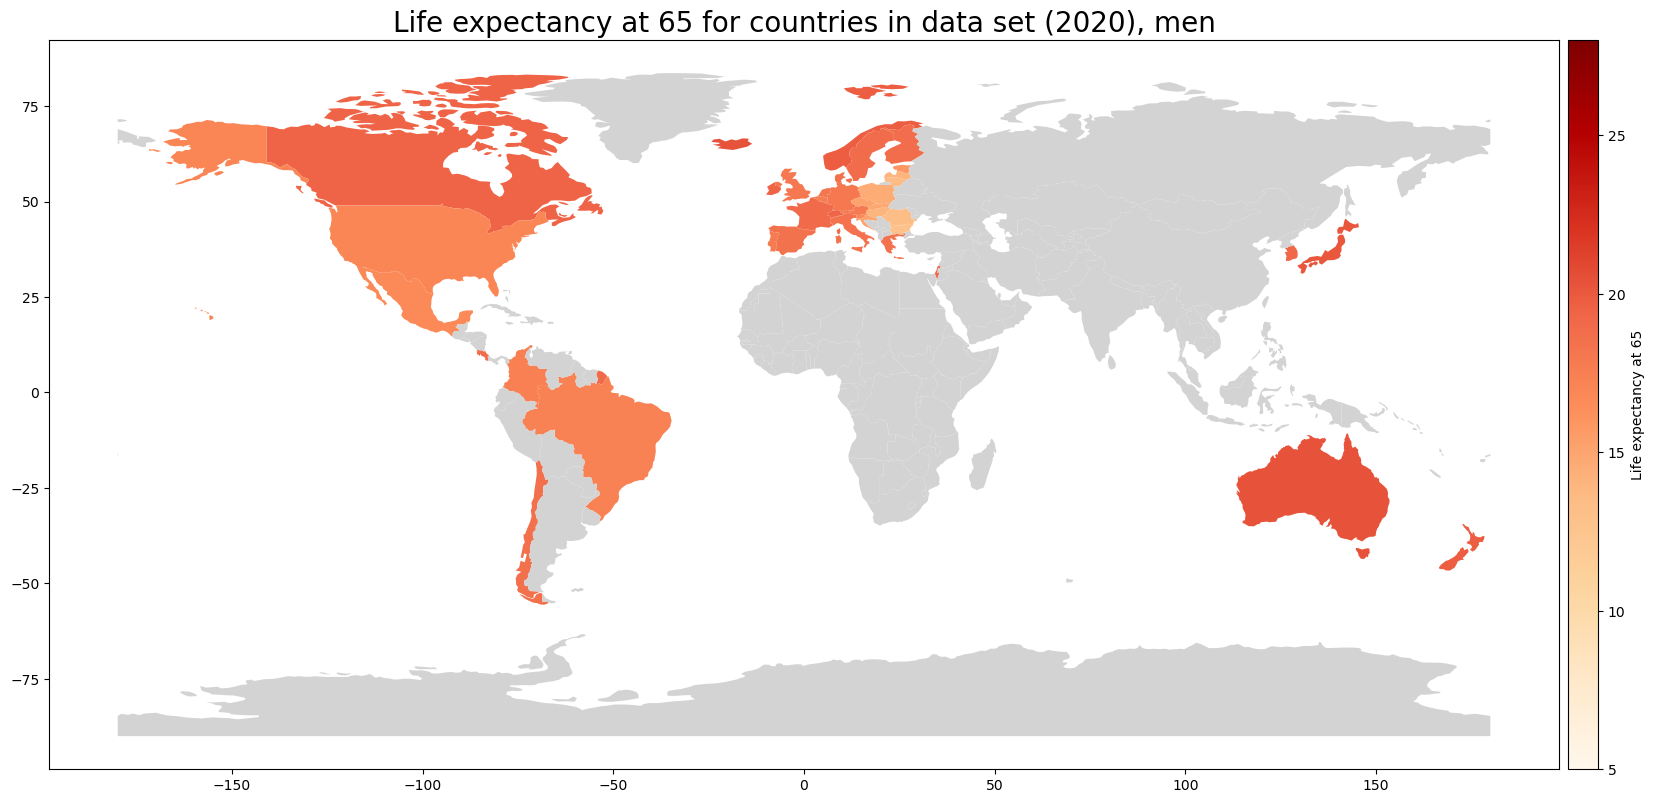

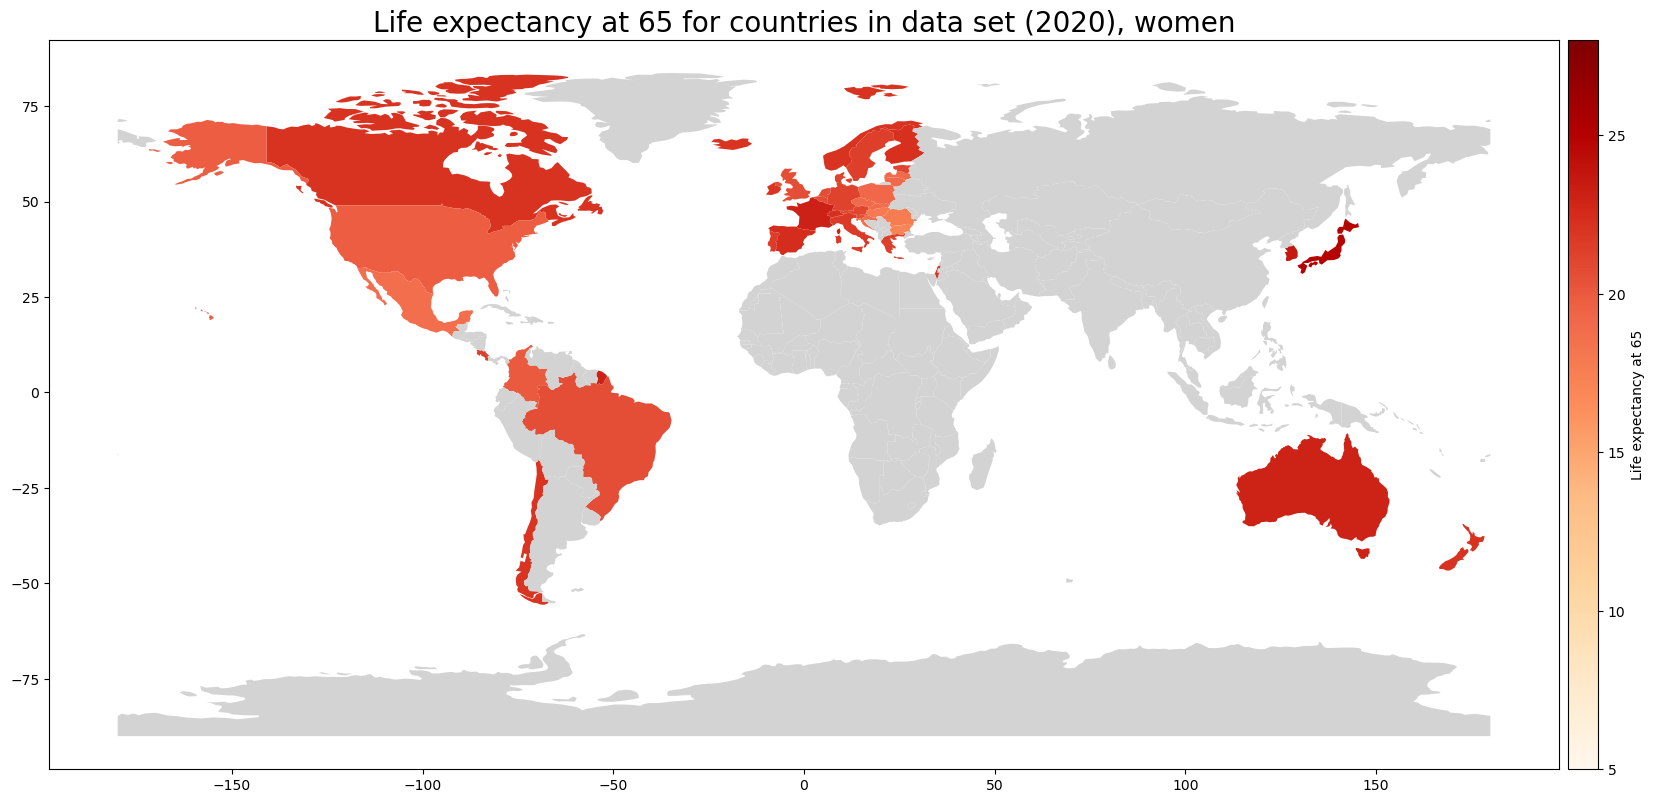

In [20]:
# making overview map for countries in data set
for data in ['Data/men_lifeexp65.csv', 'Data/women_lifeexp65.csv']:
    # rewrite to use in titles in final plot
    data_title = data.rstrip('_lifeexp65.csv').lstrip('Data/')
    # load and clean data
    mapdata = pd.read_csv(data)
    drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','TIME','Flag Codes']
    mapdata.drop(drop, axis=1, inplace=True)

    # load data to make world map
    df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # merge map data to world map
    df_world_mapdata = df_world.merge(mapdata, how="left", left_on=['iso_a3'], right_on=['LOCATION'])

    # add visuals, axes, labels and title
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad="0.5%")
    df_world_mapdata.plot(column="Value", ax=ax, cax=cax, cmap='OrRd',legend=True, legend_kwds={"label": "Life expectancy at 65"}, missing_kwds={'color':'lightgrey'}, vmin=5, vmax=28)
    ax.set_title(f'Life expectancy at 65 for countries in data set (2020), {data_title}', size=20)

We find significant differences in life expectancy for men and women in all countries, where womens' life expectancy is higher than men's. Further, we find that life expectancy varies across countries, though this difference seems to be unaffected by gender. In the following analyses we will focus on the country heterogeneity for the total population.

# Read and clean data

We import the 4 different CSV files

In [4]:
# importing data
alcohol = pd.read_csv('Data/alcohol.csv')
life_exp_65 = pd.read_csv('Data/lifeexp65.csv')
smokers = pd.read_csv('Data/smokers.csv')
social_support = pd.read_csv('Data/socsupport.csv')

### Cleaning each dataset

Our four datasets are from the same source, why the layout is similar. Thus, we create a function called dataclean (in dataproject.py) that does the basic cleaning of all data. 

Following this, we manually clean each dataset further, for their specific needs. 
For each dataset, we end up with the total series value for each country each year available. 

#### Life expentancy at 65

In [5]:
# clean life_exp_65 data
life_exp_65 = dataclean(life_exp_65, 'exp_years')
life_exp_65

,country,SUBJECT,year,exp_years
0,AUS,MEN,1960,12.5
1,AUS,MEN,1961,12.6
2,AUS,MEN,1962,12.4
3,AUS,MEN,1963,12.3
4,AUS,MEN,1964,12.0
...,...,...,...,...
4500,ROU,WOMEN,2017,18.3
4501,ROU,WOMEN,2018,18.4
4502,ROU,WOMEN,2019,18.6
4503,ROU,WOMEN,2020,17.7


In [6]:
# we find the average of men and women for each year for each country.
grouped = life_exp_65.groupby(['country','year'])['exp_years'].mean()

# we save it as a dataframe
avg_life_exp = grouped.to_frame()

# changing column name
avg_life_exp.rename(columns = {'exp_years':'avg_life_exp65'}, inplace=True)   

# printing the cleaned dataset
avg_life_exp.head()

avg_life_exp65
country year                
AUS     1960           14.05
        1961           14.15
        1962           14.00
        1963           14.05
        1964           13.75

#### Alcohol

In [7]:
alcohol = dataclean(alcohol, 'alcohol_sale')

# we drop the column "SUBJECT"
alcohol.drop('SUBJECT', axis=1, inplace=True)

# printing the clean dataset
alcohol.head()

,country,year,alcohol_sale
0,AUS,1960,9.3
1,AUS,1961,9.4
2,AUS,1962,9.5
3,AUS,1963,9.8
4,AUS,1964,10.1


#### Smokers

In [8]:
# clean smokers data
smokers = dataclean(smokers, 'smoking')

# we drop data from men and women, but keep the total 
I = smokers.SUBJECT.str.contains('WOMEN')
I |= smokers.SUBJECT.str.contains('MEN')
smokers.loc[I,:]
smokers = smokers.loc[I == False]

# we drop the column "SUBJECT"
smokers.drop('SUBJECT', axis=1, inplace=True)

# printing the clean dataset
smokers.head()

,country,year,smoking
0,AUS,1964,43.0
1,AUS,1966,40.0
2,AUS,1969,37.0
3,AUS,1974,37.8
4,AUS,1976,38.4


#### Social support

In [9]:
# clean social_support data
social_support = dataclean(social_support, 'share_support')

# we keep the values "TOT":
I = social_support.SUBJECT.str.contains('TOT')
social_support.loc[I,:]
social_support = social_support.loc[I == True]
social_support.drop('SUBJECT', axis=1, inplace=True)

# printing the clean dataset
social_support.head()

,country,year,share_support
3203,AUS,2006,96.670250
3204,AUS,2007,95.700469
3205,AUS,2008,94.188943
3206,AUS,2010,95.353709
3207,AUS,2011,96.661780


# Merge data sets

We merge our 4 datasets in an outer merge to keep all values for illustrational purposes.

In [10]:
merged = avg_life_exp.merge(alcohol, on=['country','year'],how='outer').merge(smokers, on=['country','year'],how='outer').merge(social_support,on=['country','year'],how='outer')
merged.set_index(['country','year'])

avg_life_exp65  alcohol_sale  smoking  share_support
country year                                                      
AUS     1960           14.05           9.3      NaN            NaN
        1961           14.15           9.4      NaN            NaN
        1962           14.00           9.5      NaN            NaN
        1963           14.05           9.8      NaN            NaN
        1964           13.75          10.1     43.0            NaN
...                      ...           ...      ...            ...
EST     2022             NaN           NaN      NaN      91.784568
RUS     2020             NaN           NaN      NaN      88.545778
        2021             NaN           NaN      NaN      85.969644
SVN     2022             NaN           NaN      NaN      93.825366
ZAF     2021             NaN           NaN      NaN      92.006225

[2821 rows x 4 columns]

### Descriptive statistics

For an overview of our merged dataset, we do descriptive statistics.

In [11]:
merged.describe()

,year,avg_life_exp65,alcohol_sale,smoking,share_support
count,2821.000000,2254.000000,2535.000000,875.000000,637.000000
mean,1991.961716,16.555324,8.906746,25.534171,89.762182
std,17.788173,2.318160,4.305963,10.341473,5.230220
min,1960.000000,11.650000,0.000000,7.200000,63.954697
25%,1977.000000,14.650000,6.000000,18.100000,87.168302
50%,1992.000000,16.300000,9.200000,24.500000,90.721021
75%,2007.000000,18.250000,11.600000,30.950000,93.569988
max,2022.000000,22.500000,23.600000,61.000000,98.559248



- The average life expectancy varies from 11,65 to 22,5 years alive after 65 years. 
- Alcohol sale varies from 0 to 23,6 liters of alcohol purchased annually. 
- Smoking varies from 7,2% of daily smokers to 61% of daily smokers. 
- The share of support varies from 64% to 98,6% of people having others they can count on.


In [12]:
# we look at the averages across the countries for each year to see the development
merged.groupby('year').agg(['mean']).round(1)

/var/folders/7l/ds0r5wcs2pz7_scg8504fft00000gn/T/ipykernel_38014/2169580437.py:2: FutureWarning: ['country'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  merged.groupby('year').agg(['mean']).round(1)


,avg_life_exp65,alcohol_sale,smoking,share_support
,mean,mean,mean,mean
year,,,,
1960,13.8,6.3,41.8,NaN
1961,14.2,6.6,51.0,NaN
1962,13.9,7.1,49.5,NaN
1963,14.0,7.2,48.5,NaN
1964,14.2,7.5,44.2,NaN
...,...,...,...,...
2018,19.4,8.2,16.1,89.8
2019,19.7,8.2,17.1,90.4


We observe that the average life expentancy at 65 years old has increased with time from 1960-2021. In 1960 the average person expected to live 13-14 years more at 65, where as this has increased to around 18-20 years in recent time. Alcohol sale has remained relatively stable in the period. Smoking however has decreased quite a lot in average from around 40-50% of the population being daily smokers in the 1960's to around 10-20% daily smokers in newer times. 

In addition to this, we illustrate the data in an interactive widget figure, where we display each variable of interest for each country.

In [13]:
# we define a function that creates a scatterplot of each dataseries
def plot(df, country, var):
    I=df['country']== country
    ax=df.loc[I,:].plot(x='year', y=str(var), kind = 'scatter', legend=False) 

# we define the interactive widget for a dropdown menu 
def plot_timeseries(df):
    widgets.interact(plot, 
    df = widgets.fixed(df),
    var = widgets.Dropdown(
        description='variable', 
        options=['avg_life_exp65', 'alcohol_sale','smoking','share_support'], 
        value='avg_life_exp65'),
    country = widgets.Dropdown(
        description='country', 
        options=df.country.value_counts().index.to_list(), 
        value='AUS')          
);

plot_timeseries(merged)

interactive(children=(Dropdown(description='country', options=('AUS', 'DEU', 'NOR', 'NZL', 'POL', 'JPN', 'PRT'…

Due to missing data, not all countries have data in the drop-down graph for all variables.

# Regression

We do an inner merge of the data for our regression analysis, where we discard countries and years for which we do not have a complete dataseries.

In [14]:
mergedregress= avg_life_exp.merge(alcohol, on=['country','year'],how='inner').merge(smokers, on=['country','year'],how='inner').merge(social_support,on=['country','year'],how='inner')
mergedregress.set_index(['country','year'])

avg_life_exp65  alcohol_sale  smoking  share_support
country year                                                      
AUS     2007           20.05          10.8     16.9      95.700469
        2010           20.35          10.4     15.3      95.353709
        2013           20.65           9.9     13.0      92.723545
        2016           20.95           9.5     12.4      93.608335
AUT     2006           19.00          12.5     23.2      91.604918
...                      ...           ...      ...            ...
USA     2016           19.35           8.9     11.8      89.578977
        2017           19.30           8.9     10.5      92.062038
        2018           19.40           8.9     10.3      90.352401
        2019           19.50           9.0     10.9      91.518385
        2020           18.40           9.3      9.4      93.536969

[311 rows x 4 columns]

We perform a fixed effects regression of life expenctancy at 65 (lifeexp65) on the 3 selected health risks (alcohol_sale, smoking, share_support), where we take into account the time and country effects. Entity effects take the individual heterogeneity of each country into account and time effects take the yearly effects across all countries into account.

The regression equation is given by:

$$LifeExp65 = \beta_0 +\beta_1\cdot AlcoholSale + \beta_2 \cdot Smoking + \beta _3 \cdot ShareSupport + EntityEffects + TimeEffects$$

where $\beta_0$ is a constant term with no intuitive interpretation.

In [15]:
# we create a multi-index
index = pd.MultiIndex.from_frame(mergedregress[['country', 'year']])

# we create the dataframe we will regress on
regression = pd.DataFrame(mergedregress[mergedregress.columns.to_list()[2:]].values ,index=index, columns=['LifeExp65','AlcoholSale','Smoking','ShareSupport'])

# we perform the regression
mod = PanelOLS.from_formula("LifeExp65 ~ 1 + AlcoholSale + Smoking + ShareSupport + EntityEffects + TimeEffects", data=regression)

# we a variable for the model results, using clustered standard deviations
res = mod.fit(cov_type='clustered', cluster_entity=True)

# we print the regression output as well as all parameter values
print(res)
res.params

                          PanelOLS Estimation Summary                           
Dep. Variable:              LifeExp65   R-squared:                        0.0682
Estimator:                   PanelOLS   R-squared (Between):              0.0594
No. Observations:                 311   R-squared (Within):               0.1078
Date:                Tue, May 23 2023   R-squared (Overall):              0.0666
Time:                        12:20:47   Log-likelihood                   -56.604
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.1734
Entities:                          40   P-value                           0.0005
Avg Obs:                       7.7750   Distribution:                   F(3,253)
Min Obs:                       2.0000                                           
Max Obs:                       16.000   F-statistic (robust):             2.2990
                            

Intercept       17.710578
AlcoholSale     -0.082405
ShareSupport     0.027719
Smoking         -0.003923
Name: parameter, dtype: float64

### Results

Our regression analysis shows that alcohol and smoking has a negative effect on life expectency at 65 years, while social support has a positive effect. These results are as expected. More precisely,

*  When annual alcohol sales increase with one liter of pure alcohol, the life expectancy at age 65 decreases with 0.082 years. 
* When the share of everyday smokers increase with one percent, the life expectancy at age 65 decreases with 0.004 years. 
* When the share of people reporting having a social safety net increase with one percent, the life expectancy at age 65 increases with 0.028 years.

However, our results are not significant at a 5% significance level. This might be due to omitted variables such as education, income and other health related variables. Furthermore, our data cleaning process removes a lot of the data, which leaves us with a rather small datasample. 